<a href="https://colab.research.google.com/github/olivierlubet/IBM_advanced_datascience_Coursera_Capstone/blob/master/GDN_Analysis_step_4_model_def_python_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grand Débat National - Model definition - Model training - Model evaluation


## Installation - imports - utility functions

In [101]:

!pip install yellowbrick
!pip3 install seaborn==0.9.0

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.manifold import TSNE


import pandas as pd
import json

from datetime import datetime

import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import *
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.utils import plot_model
from keras.callbacks import *

import numpy as np
import tensorflow as tf

from yellowbrick.cluster import KElbowVisualizer


from IPython.display import Image

import matplotlib.pyplot as plt


In [0]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# Loading data

In [104]:
data = np.load('GDN.384.npy')
data.shape

(2000, 384)

# Determining the K for K-means - Elbow method

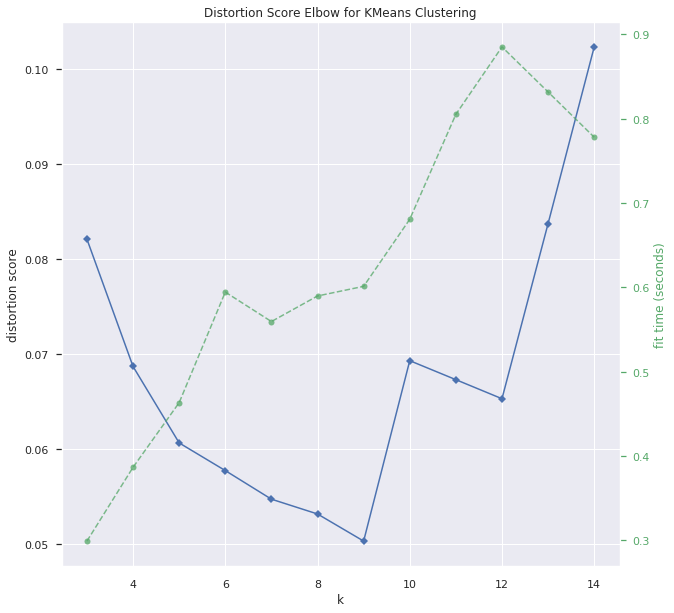

In [105]:

plt.figure(figsize=(10, 10))
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))#, metric='silhouette')

visualizer.fit(data)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

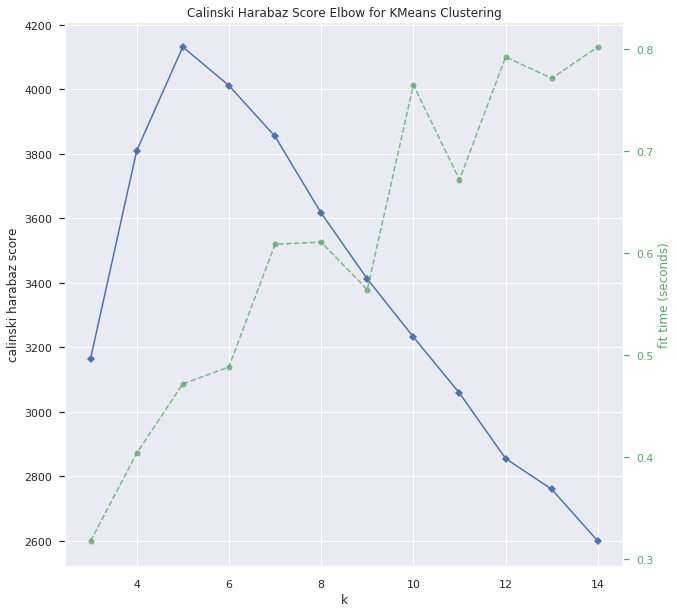

In [106]:

plt.figure(figsize=(10, 10))
visualizer = KElbowVisualizer(model, k=(3,15), metric='calinski_harabaz')

visualizer.fit(data)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

The elbow method shows us that an optimal K is between 5 and 8

In [0]:
n_clusters = 8
cmap = get_cmap(n_clusters)
points_2d = TSNE(n_components=2).fit_transform(data)

# Model definition and training for K-Mean with SKLearn

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=100)
y_pred_skl = kmeans.fit_predict(data)


In [174]:
np.unique(y_pred_skl,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([423, 477, 143, 339,  81, 193, 248,  96]))

 # Model definition and training for K-Means with Tensorflow

In [113]:
points_n = 200
iteration_n = 100

points = tf.constant(data)
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [n_clusters, -1]))

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)

distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)

means = []
for c in range(n_clusters):
    means.append(tf.reduce_mean(
      tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))

new_centroids = tf.concat(means,axis=0)

update_centroids = tf.assign(centroids, new_centroids)
init = tf.initialize_all_variables()

with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, y_pred_tf] = sess.run([update_centroids, centroids, points, assignments])
    
  print ("centroids" + "\n", centroid_values)


centroids
 [[-1.5148552e-02 -3.2059062e-02  3.7229121e-02 ... -1.0596385e-02
  -4.3271303e-02  1.4775349e-02]
 [-1.2824349e-02 -1.1575032e-02 -1.5309694e-02 ... -1.1407200e-02
   1.7297465e-02 -3.0442089e-02]
 [-1.2310841e-02 -2.5037969e-02  2.0429431e-02 ... -1.1242220e-02
  -1.1296851e-02 -3.1657804e-02]
 ...
 [-8.1867613e-03 -1.8019523e-02 -8.6736611e-05 ... -8.5719172e-03
   1.3865239e-02 -3.3388324e-02]
 [-2.5004057e-02 -9.0793436e-03 -1.7150167e-02 ... -2.1720633e-02
   8.2839429e-03 -2.0177562e-02]
 [-1.3961757e-02 -3.0364575e-02  3.3443566e-02 ... -1.1282052e-02
  -3.2429542e-02 -4.2154551e-03]]


In [114]:
np.unique(y_pred_tf,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([315, 166, 389, 477, 163, 193, 148, 149]))

# Models evaluation

## Accuracy of the different models - euclidean distance

### SKLearn K-Means

In [169]:
y_pred_skl_center = np.array([kmeans.cluster_centers_[x] for x in y_pred_skl])
np.sum(np.min(pairwise_distances(data,y_pred_skl_center),axis=0))

65.27759

### Tensorflow K-Means

In [170]:
y_pred_tf_center = np.array([centroid_values[x] for x in y_pred_tf])
np.sum(np.min(pairwise_distances(data,y_pred_tf_center),axis=0))

65.75744

## Similarity of clusters - Confusion matrix

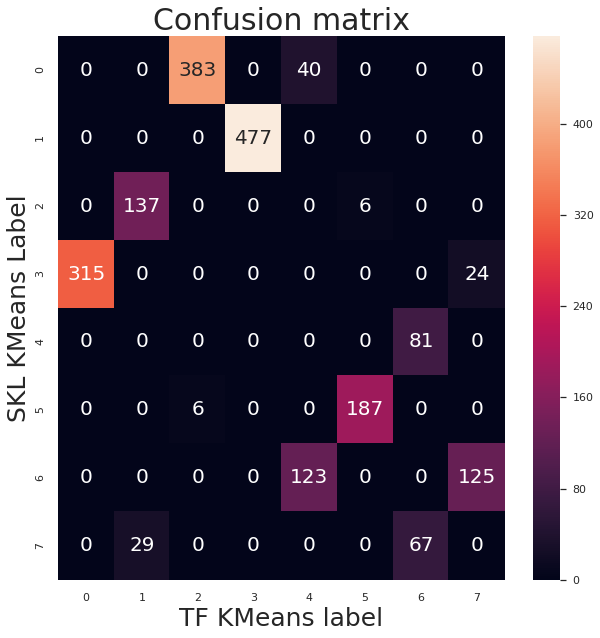

In [117]:
sns.set(font_scale=1)
conf_mat = confusion_matrix(y_pred_skl, y_pred_tf)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('SKL KMeans Label', fontsize=25)
plt.xlabel('TF KMeans label', fontsize=25)
plt.show()

##Visual representation - SK Learn K-Means



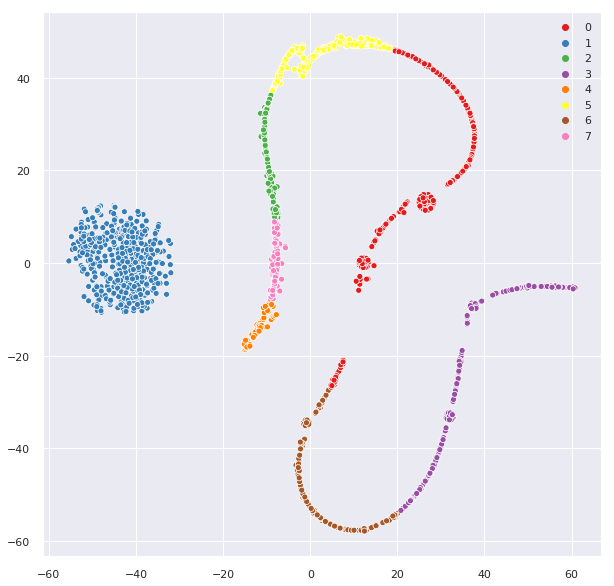

In [171]:
plt.figure(figsize=(10, 10))
sns.scatterplot(points_2d[:,0],points_2d[:,1],hue=y_pred_skl,palette=sns.color_palette("Set1", n_colors=n_clusters))

##Visual representation - Tensorflow K-Means

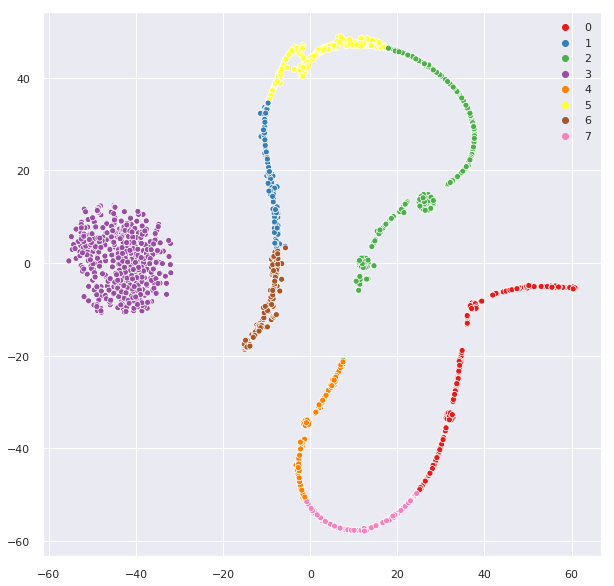

In [172]:
plt.figure(figsize=(10, 10))
sns.scatterplot(points_2d[:,0],points_2d[:,1],hue=y_pred_tf,palette=sns.color_palette("Set1", n_colors=n_clusters))

## Text samples - main topics and outliers

In [0]:
df = pd.read_csv('GDN.txt',header=None,).rename(columns={0:'text'})
df['skl_cluster']=y_pred_skl
df['tf_cluster']=y_pred_tf
df['dist_from_tf_centroid'] = np.min(pairwise_distances(data,y_pred_tf_center),axis=0)
df_asc = df.sort_values('dist_from_tf_centroid')
df_desc = df.sort_values('dist_from_tf_centroid',ascending=False)

In [176]:
df.head(5)

,text,skl_cluster,tf_cluster,dist_from_tf_centroid
0,Economiser l'eau et les autres ressources naturelles Limiter l'utilisation des produits polluants,5,5,0.021836
1,Les transports en commun,3,0,0.003588
2,TAXER L'ESSENCE ET LE DIESEL !! BAISSER LE PRIX DES TRANSPORT EN COMMUN : aujourd'hui le train est beaucoup trop cher par rapport à la voiture lorsque qu'on est une famille.,4,6,0.041621
3,tout le monde! Il faut que tout le monde prennent conscience de la situation....,0,2,0.008382
4,"Pesée au niveau communal des déchets recyclés, puis comparaison au niveau national (par tête) pour attribuer des bonus et des malus au niveau des impôts locaux. Établir des contrats de consommation énergétique globalement avantageux pour les faibles consommations mais avec une augmentation rapide des prix après un certain seuil, ou encore globalement avantageux à l'année mais avec des malus dans les pics de consommation ou pour les consommations inutiles (lumière le jour, chauffage l'été...)",1,3,0.095622


In [0]:
pd.set_option('display.max_colwidth', -1)

In [173]:
for i in range(n_clusters):
  print('Cluster ',i,' answer nb:',df_asc[df_asc.tf_cluster==i].text.count())
  print()
  print('Answers near centroid')
  print(df_asc[df_asc.tf_cluster==i].head(5).text)
  print()
  print('Outliers')
  print(df_desc[df_desc.tf_cluster==i].head(5).text)
  print()
  print()

Cluster  0  answer nb: 315

Answers near centroid
403     Maladies / cancers de nos proches
908     déjà fait                        
439     La pollution de l'air            
1384    régulation de chauffage efficace 
1225    je fais déjà tout ça             
Name: text, dtype: object

Outliers
77      Incitations fiscales            
231     Montrer l'exemple.              
893     La démographie                  
880     Aide et  credit d impot         
1678    Tous ces éléments vont ensemble.
Name: text, dtype: object


Cluster  1  answer nb: 166

Answers near centroid
1901    A 71 ans je ne pense pas avoir besoin de vous pour me déplacer et je ne compte pas sur l'état l'assistanat ça suffit.                    
1290    Appliquer les mesures contraignantes à tous les usagers de son territoire, qu'ils résident en France ou dans un autre pays européen.     
531     Il y a un gaspillage important d'énergie du au TV, ordinateur, tablette, GSM toujours en veille donc à maintenir branchés